In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


<ipython-input-8-82aae8b3f7a9>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  display(train[target].head(3))


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [10]:
len(features)

3159

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]

In [12]:
len(features)

309

In [13]:
pd.DataFrame(train.groupby(["year","month"])["id"].agg('count'))

id
year   month      
1999.0 11.0     87
2000.0 2.0      50
       3.0      37
       4.0       8
2001.0 12.0     16
2002.0 7.0      25
       10.0     46
2003.0 2.0      24
       3.0      30
2006.0 4.0       3
2009.0 1.0     418
       4.0     418
       7.0     418
       9.0      96
       10.0   1154
       11.0    524
       12.0    653
2010.0 1.0     215
       6.0     114
       7.0      77
       8.0     735
       9.0     217
       10.0     78
       11.0    150
       12.0    834
2011.0 1.0     101
       2.0     237
       3.0     115
       4.0     234
       6.0     527
       7.0     376
       8.0     184
       9.0    1438
       10.0    204
       11.0     30
       12.0     12
2012.0 1.0       6
       2.0      95
2019.0 8.0     825
       9.0     899
       10.0   2345
       12.0     44
2020.0 2.0      41

In [14]:
pd.DataFrame(test.groupby(["year","month"])["id"].agg("count"))

id
year   month      
2002.0 7.0      84
       12.0     84
2004.0 2.0      41
2009.0 9.0      67
       10.0     43
       11.0    118
       12.0    178
2010.0 1.0      30
       3.0      15
       6.0     455
       7.0     545
       8.0     118
       10.0     95
       11.0     31
       12.0      8
2011.0 1.0      57
       3.0       3
       4.0     112
       7.0      15
       9.0     103
       10.0      8
2012.0 2.0      36
2013.0 9.0      19
2014.0 7.0      65
       9.0      21
       10.0     44
2019.0 9.0     584
       10.0   1060

## Model

In [15]:
#!pip install iterative-stratification

In [16]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, GroupShuffleSplit, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, cross_val_score
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from multiprocessing import cpu_count

In [17]:
class CFG:
  debug=False
  ver=67
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  timesplit=5
  seed=42
  target_cols="cover"
  boosting_type="gbdt"
  fold_target="cover"
  fold_group="year"

In [18]:
#features = list(features)
features.remove('id')
#features.remove('area')
features.remove("year")
#features.remove("month")
#features.append("mesh20")

In [19]:
params = [{
        'objective': ['regression'],
        'metric': ['rmse'],
        'learning_rate': [0.1, 0.05],
        'boosting': [CFG.boosting_type],
        'seed': [CFG.seed],
        "reg_alpha": [0.3],
        #"reg_lambda": [0.5],
        "n_estimators": [1000],
        'min_child_weight': [1, 5],
        "max_depth": [3, 5, 7],
        "colsample_bytree": [0.4, 0.7],
        "max_leaves": [int(.7 * 5 ** 2)]
    }]

In [20]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

def rmse(y_true,y_pred):
    #RMSEを算出
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('RMSE : ',rmse)
    return rmse

def get_pred(train, test, target_cols, model, fold_groups, candidate_params):

  oof_df = pd.DataFrame()
  pred_df = pd.DataFrame()

  test_years = np.sort(test.year.unique())

  inner_cv = TimeSeriesSplit(n_splits=CFG.timesplit)
  clf = model
  for year in test_years:
    print("="*15,f" OUTER CV Year = {year} ","="*15)
    outer_train = train.loc[train["year"]<year].reset_index(drop=True)
    outer_valid = train.loc[train["year"]==year].reset_index(drop=True)
    pred_test = test.loc[test["year"]==year].reset_index(drop=True)

    valid_len = len(outer_valid)
    if valid_len==0:
      test_X = pred_test[features].values
      pred_test["pred"] = gs.best_estimator_.predict(test_X)
      pred_df = pd.concat([pred_df, pred_test])
      continue


    outer_tr_X = outer_train[features].values
    outer_va_X = outer_valid[features].values
    test_X = pred_test[features].values
    outer_tr_y = outer_train[target_cols].values
    outer_va_y = outer_valid[target_cols].values

    gs = GridSearchCV(estimator=clf,
                      param_grid=candidate_params,
                      cv=inner_cv,
                      scoring=make_scorer(mean_squared_error,greater_is_better=False),
                      return_train_score=True,
                      n_jobs=-1)
    gs.fit(outer_tr_X, outer_tr_y,
           eval_set=[(outer_va_X, outer_va_y)],
           early_stopping_rounds=50,
           verbose = 500)
    print('The best parameter = ', gs.best_params_)

    outer_valid["pred"] = gs.best_estimator_.predict(outer_va_X)
    oof_df = pd.concat([oof_df, outer_valid])

    print('RMSE = ',mean_squared_error(outer_va_y, outer_valid["pred"], squared=False))

    pred_test["pred"] = gs.best_estimator_.predict(test_X)
    pred_df = pd.concat([pred_df, pred_test])

  pred_df.sort_values("id").reset_index(drop=True)

  return oof_df, pred_df

In [21]:
%%time
if CFG.debug:
  print(train.shape)
  train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)
  #train.sort_values("year-month").reset_index(drop=True)
  print(train.shape)


model = lgb.LGBMRegressor()
oof_df, pred_df = get_pred(train, test, CFG.target_cols, model, CFG.fold_group, params)

===============  OUTER CV Year = 2002.0  ===============


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_leaves is set=31, max_leaves=17 will be ignored. Current value: num_leaves=31
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 17, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.3, 'seed': 42}
RMSE =  0.1911433257842345
===============  OUTER CV Year = 2004.0  ===============
===============  OUTER CV Year = 2009.0  ===============


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_leaves is set=31, max_leaves=17 will be ignored. Current value: num_leaves=31
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 17, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.3, 'seed': 42}
RMSE =  0.3012063663890168
===============  OUTER CV Year = 2010.0  ===============


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_leaves is set=31, max_leaves=17 will be ignored. Current value: num_leaves=31
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 17, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.3, 'seed': 42}
RMSE =  0.14242726962993352
===============  OUTER CV Year = 2011.0  ===============


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_leaves is set=31, max_leaves=17 will be ignored. Current value: num_leaves=31
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'max_leaves': 17, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.3, 'seed': 42}
RMSE =  0.14209611276906314
===============  OUTER CV Year = 2012.0  ===============


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_leaves is set=31, max_leaves=17 will be ignored. Current value: num_leaves=31
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 17, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.3, 'seed': 42}
RMSE =  0.10013322632544759
===============  OUTER CV Year = 2013.0  ===============
===============  OUTER CV Year = 2014.0  ===============
===============  OUTER CV Year = 2019.0  ===============


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_leaves is set=31, max_leaves=17 will be ignored. Current value: num_leaves=31
The best parameter =  {'boosting': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 17, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'reg_alpha': 0.3, 'seed': 42}
RMSE =  0.28237303644336
CPU times: user 25.6 s, sys: 1.8 s, total: 27.4 s
Wall time: 14min 6s


In [22]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
rmse(_oof["cover"], _oof["pred"])

RMSE :  0.23802607589439861


0.23802607589439861

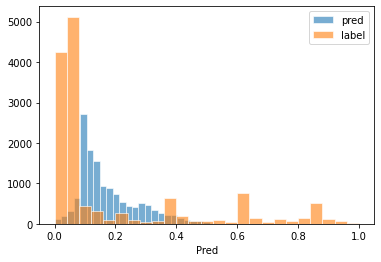

In [23]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

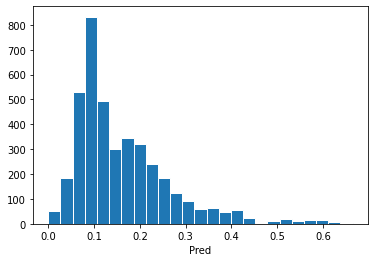

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0.175622
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0.142502
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,0.198759
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,0.069214
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,0.388540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.260930,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,0.112142
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.286240,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,0.085215
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.316359,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,0.198759
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.302570,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,0.099660


In [27]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else cover_max)
pred_df = pred_df.sort_values("id").reset_index(drop=True)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)